In [ ]:
import pandas as pd
import numpy as np
import datetime
import glob
import os
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
# Path to the directory containing folders for each year in Google Drive
drive_dir = '/content/drive/MyDrive/Dataset - 2018-2022/'
# Get a list of all year folders
year_folders = [folder for folder in os.listdir(drive_dir) if os.path.isdir(os.path.join(drive_dir, folder))]
year_folders.sort()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_set = set()
from datetime import datetime
for year_folder in year_folders:
    # Get a list of all CSV files in the year's folder with the format cm<DD><MMM><YYYY>.csv
    file_list = glob.glob(drive_dir + year_folder + '/cm*.csv')
  # Extract and convert dates from file names
    file_dates = [datetime.strptime(os.path.basename(file_path)[2:-8], '%d%b%Y') for file_path in file_list]

    # Sort files by date
    file_list_sorted = [file_path for _, file_path in sorted(zip(file_dates, file_list))]

    # Process each CSV file and adding to a list
    for file_path in file_list_sorted:
      file_set.add(file_path)

In [ ]:
def file_format(s_date):
  v_date = drive_dir + str(s_date.year) + '/cm'+ str(s_date.day).zfill(2) + month[s_date.month] + str(s_date.year) +'bhav.csv'
  return v_date

def valid_date(date1, date2):
  start_file = ""
  while(date1>date2):
    start_file = file_format(date1)
    if(start_file in file_set):
      break
    date1 = date1 - datetime.timedelta(days=1)
  return start_file, date1


In [ ]:
# Initialize an empty DataFrame
final_df = pd.DataFrame(columns=['SYMBOL'])
############################################################################Function to calculate 3month return on a weekly basis################################################
def calculate_3mo_return(file1, file2, week_number, date1, date2):
    global final_df  # Use global final_df for modification

    # Load CSV file into DataFrame
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)

    # Filter data to include only series 'EQ'
    data1 = data1[data1['SERIES'] == 'EQ']
    data2 = data2[data2['SERIES'] == 'EQ']

    # Concatenate SYMBOL and SERIES to create a unique identifier
    data1['UNIQUE_ID'] = data1['SYMBOL'] + '_' + data1['SERIES']
    data2['UNIQUE_ID'] = data2['SYMBOL'] + '_' + data2['SERIES']

    # Set 'UNIQUE_ID' as the index for both DataFrames
    data1.set_index('UNIQUE_ID', inplace=True)
    data2.set_index('UNIQUE_ID', inplace=True)

    # Find common symbols
    common_symbols = data1.index.intersection(data2.index)

    # Iterate over common symbols
    for symbol in common_symbols:
        closing_price_file1 = data1.loc[symbol, 'CLOSE']
        closing_price_file2 = data2.loc[symbol, 'CLOSE']
        ret = (closing_price_file1 - closing_price_file2) * 100 / closing_price_file2
        week_column_name = f'Week{week_number} ' + f'({date1}' + f' to{date2})'
        # Check if symbol already in final_df
        if symbol in final_df.index:
            final_df.loc[symbol, week_column_name] = ret
        else:
            new_row = pd.DataFrame({week_column_name: [ret]}, index=[symbol])
            final_df = pd.concat([final_df, new_row])

    # Save to CSV
    final_df.to_csv('return_values.csv', index=True)

In [ ]:
from dateutil.relativedelta import relativedelta
import datetime
month = {1:'JAN', 2:'FEB', 3:'MAR', 4:'APR', 5:'MAY', 6:'JUN', 7:'JUL', 8:'AUG', 9:'SEP', 10:'OCT', 11:'NOV', 12:'DEC'}
# Define the start and end dates for the backtesting period
start_date = datetime.date(2018, 4, 8)
end_date = datetime.date(2023, 1, 1)  # 4-year period

i=1
while(end_date >= start_date):
  # print("Week: ",i)
  prior_start_week = start_date - datetime.timedelta(days=7)
  file1, date1= valid_date(start_date, prior_start_week)
  # Calculate 3 months back
  three_months_earlier = date1 - relativedelta(months=3)
  prior_end_week = three_months_earlier - datetime.timedelta(days=7)
  file2, date2 = valid_date(three_months_earlier, prior_end_week )
  print(file1, file2)
  calculate_3mo_return(file1, file2,i, date1, date2)
  i = i + 1
  start_date = start_date + datetime.timedelta(days=7)
print(i)

In [ ]:
new_file = drive_dir + 'return_values.csv'
# Load your CSV file into a DataFrame
df = pd.read_csv(new_file)

# Extract column headings
row_headings = df['SYMBOL']
column_headings = df.columns.tolist()
############################################################################Function to calculate 6 month return on a weekly basis################################################
def calculate_6month_return_for_stock(symbol_list):
    results = []

    for symbol in symbol_list:
        # Get the row for the specified stock
        stock_row = df[df['SYMBOL'] == symbol].reset_index(drop=True)
        six_mo_returns = []

        for i in range(len(column_headings)-13-1):
            j = i + 13 + 1
            returns = stock_row.iloc[0, i+1]  # Get 3-Month Return from first column
            returns1 = stock_row.iloc[0, j]   # Get 3-Month Return from second column
            six_mo_return = ((1 + returns / 100) * (1 + returns1 / 100) - 1) * 100
            six_mo_returns.append(six_mo_return)

        # Store results in a dictionary
        result = {'SYMBOL': symbol}
        for idx, return_val in enumerate(six_mo_returns, start=1):
            result[f'6-Month Return {idx}'] = return_val

        # Append to the results list
        results.append(result)

    # Create DataFrame from the results
    results_df = pd.DataFrame(results)

    return results_df

# Calculate 6-month returns for stocks and get the resulting DataFrame
six_month_return_for_stock_df = calculate_6month_return_for_stock(row_headings)

# Save the result to a new CSV file
output_csv = drive_dir+ "return_values_6mo.csv"
six_month_return_for_stock_df.to_csv(output_csv, index=False)


In [ ]:
new_file = drive_dir + 'return_values_6mo.csv'
# Load your CSV file into a DataFrame
df = pd.read_csv(new_file)

# Extract column headings
row_headings = df['SYMBOL']
column_headings = df.columns.tolist()
############################################################################Function to calculate 12 month return on a weekly basis################################################
def calculate_12month_return_for_stock(symbol_list):
    results = []

    for symbol in symbol_list:
        # Get the row for the specified stock
        stock_row = df[df['SYMBOL'] == symbol].reset_index(drop=True)
        twelve_mo_returns = []

        for i in range(len(column_headings)-26 - 1):
            j = i + 26 + 1
            returns = stock_row.iloc[0, i+1]  # Get 3-Month Return from first column
            returns1 = stock_row.iloc[0, j]   # Get 3-Month Return from second column
            twelve_mo_return = ((1 + returns / 100) * (1 + returns1 / 100) - 1) * 100
            twelve_mo_returns.append(twelve_mo_return)

        # Store results in a dictionary
        result = {'SYMBOL': symbol}
        for idx, return_val in enumerate(twelve_mo_returns, start=1):
            result[f'12-Month Return {idx}'] = return_val

        # Append to the results list
        results.append(result)

    # Create DataFrame from the results
    results_df = pd.DataFrame(results)

    return results_df

# Calculate 6-month returns for stocks and get the resulting DataFrame
twelve_month_return_for_stock_df = calculate_12month_return_for_stock(row_headings)

# Save the result to a new CSV file
output_csv = drive_dir+ "return_values_12mo.csv"
twelve_month_return_for_stock_df.to_csv(output_csv, index=False)

In [ ]:
new_file1 = drive_dir + 'return_values.csv'
new_file2 = drive_dir + 'return_values_6mo.csv'
new_file3 = drive_dir + 'return_values_12mo.csv'
# Load your CSV file into a DataFrame
df1 = pd.read_csv(new_file1)
df2 = pd.read_csv(new_file2)
df3 = pd.read_csv(new_file3)

row_headings = df1['SYMBOL']
column_headings1 = df1.columns.tolist()
column_headings2 = df2.columns.tolist()
column_headings3 = df3.columns.tolist()

def weighted_average(symbol_list):
  results = []

  for symbol in symbol_list:
      # Get the row for the specified stock
      stock_row1 = df1[df1['SYMBOL'] == symbol].reset_index(drop=True)
      stock_row2 = df2[df2['SYMBOL'] == symbol].reset_index(drop=True)
      stock_row3 = df3[df3['SYMBOL'] == symbol].reset_index(drop=True)
      weighted_returns = []
      i=0
      for i in range(len(column_headings3)-1):
        index_12 = i + 1
        index_6 = i + 27
        index_3 = i + 40
        val1 = stock_row1.iloc[0, index_3]  # Get 3-Month Return
        val2 = stock_row2.iloc[0, index_6]  # Get 6-Month Return
        val3 = stock_row3.iloc[0, index_12]  # Get 12-Month Return
        weighted_return = (1*val1 + 2*val2 + 3*val3)/6
        weighted_returns.append(weighted_return)

      # Store results in a dictionary
      result = {'SYMBOL': symbol}
      for idx, return_val in enumerate(weighted_returns, start=1):
          result[f'Weighted Return {idx}'] = return_val

      # Append to the results list
      results.append(result)

  # Create DataFrame from the results
  results_df = pd.DataFrame(results)

  return results_df

weighted_return_for_stock_df = weighted_average(row_headings)
# Save the result to a new CSV file
output_csv = drive_dir+ "weighted_return.csv"
weighted_return_for_stock_df.to_csv(output_csv, index=False)

In [ ]:
# Load the CSV file
input_csv = drive_dir + "weighted_return.csv"
df = pd.read_csv(input_csv)

# Create a new DataFrame to store organized stocks
organized_df = pd.DataFrame()

# Iterate through each week
for col in df.columns[1:]:
   # Sort stocks for this week
    sorted_df = df[['SYMBOL', col]].sort_values(by=col, ascending=False)

    # Add return values in parentheses to the stock names
    sorted_df['Stock Name'] = sorted_df['SYMBOL'] + '(' + sorted_df[col].astype(str) + ')'

    # Store the sorted stocks for this week
    organized_df[col] = sorted_df['Stock Name'].tolist()

# Save the result to a new CSV file
output_csv =drive_dir+ "organized_stocks.csv"
organized_df.to_csv(output_csv, index=False)

In [ ]:
input_csv = drive_dir + "organized_stocks.csv"
df = pd.read_csv(input_csv)
input_csv_3mo = drive_dir + "return_values.csv"
top_30_stocks = {}
stock_values = {}
df_row = pd.read_csv(input_csv_3mo)
for col in df.columns:
    top_30_stocks[col] = df[col][0:30].tolist()
# Initialize a dictionary to store top 30 stocks for each column

split_string = df_row.columns[40].split('(')[1].split(')')[0]
first_date_string = split_string.split(' to')[0]
first_date = datetime.strptime(first_date_string, '%Y-%m-%d')
input_file = drive_dir + str(first_date.year) + '/cm' + str(first_date.day).zfill(2) + month[first_date.month] + str(first_date.year) + 'bhav.csv'
df3 = pd.read_csv(input_file)
df3 = df3[df3['SERIES'] == 'EQ']
df3['UNIQUE_ID'] = df3['SYMBOL'] + '_' + df3['SERIES']
df3.set_index('UNIQUE_ID', inplace=True)

for stock in top_30_stocks[df.columns[0]]:
  stock_name = stock.split('(')[0]
  closing_price_file1 = df3.loc[stock_name, 'CLOSE']
  stock_values[stock_name] = closing_price_file1


realized_pnl = 0
unrealized_pnl = 0
initial_cap = 10000000
i = 0
winners = 0
losers = 0
scratched = 0
positive_pandl = 0
negative_pandl = 0
perf = []
unrealized_perf = []


for col in df.columns:
    if(i==0):
      i = i + 1
    else:
      split_string = df_row.columns[i+40].split('(')[1].split(')')[0]
      first_date_string = split_string.split(' to')[0]
      first_date = datetime.strptime(first_date_string, '%Y-%m-%d')
      input_file = drive_dir + str(first_date.year) + '/cm' + str(first_date.day).zfill(2) + month[first_date.month] + str(first_date.year) + 'bhav.csv'
      print(input_file)
      df3 = pd.read_csv(input_file)
      df3 = df3[df3['SERIES'] == 'EQ']
      df3['UNIQUE_ID'] = df3['SYMBOL'] + '_' + df3['SERIES']
      df3.set_index('UNIQUE_ID', inplace=True)
      top_30_stocks[col] = df[col][0:30].tolist()
      temp = []
      temp_pnl = 0
      wi=0
      lo=0
      wi_pnl =0
      lo_pnl=0
      for stock in top_30_stocks[col]:
        temp.append(stock.split('(')[0])
      for stock in temp:
        if stock not in stock_values:
          stock_values[stock] = df3.loc[stock, 'CLOSE']
        else:
          pandl = (df3.loc[stock, 'CLOSE'] - stock_values[stock])*initial_cap/(30*stock_values[stock])
          temp_pnl = temp_pnl + pandl
          if(pandl>=0):
            wi = wi+1
            wi_pnl = wi_pnl+pandl
          else:
            lo=lo+1
            lo_pnl=lo_pnl + pandl
      unrealized_perf.append(temp_pnl)

      keys_to_delete = []
      for stock in stock_values:
        if stock not in temp:
          if stock not in df3.index:
            print(stock)
            pandl = 0
          else:
            pandl = (df3.loc[stock, 'CLOSE'] - stock_values[stock])*initial_cap/(30*stock_values[stock])
          if(pandl > 0):
            winners = winners + 1
            positive_pandl = positive_pandl + pandl
          elif(pandl < 0):
            losers = losers + 1
            negative_pandl = negative_pandl + pandl
          else:
            scratched = scratched + 1
          realized_pnl = realized_pnl + pandl
          keys_to_delete.append(stock)
      perf.append(realized_pnl)

      for key in keys_to_delete:
          if key in stock_values:
              del stock_values[key]
      i=i+1

positive_pandl = positive_pandl + wi_pnl
negative_pandl = negative_pandl + lo_pnl
winners = winners + wi
losers = losers + lo
# print(perf, unrealized_perf, winners, losers,scratched, positive_pandl, negative_pandl)

In [ ]:
def max_drawdown(net_pnl):
    max_dd = 0
    peak = net_pnl[0]
    trough = net_pnl[0]

    for i in range(1, len(net_pnl)):
        if net_pnl[i] > peak:
            peak = net_pnl[i]
            trough = net_pnl[i]
        elif net_pnl[i] < trough:
            trough = net_pnl[i]

        dd = (peak - trough) / peak
        max_dd = max(max_dd, dd)

    return max_dd

208 208
208


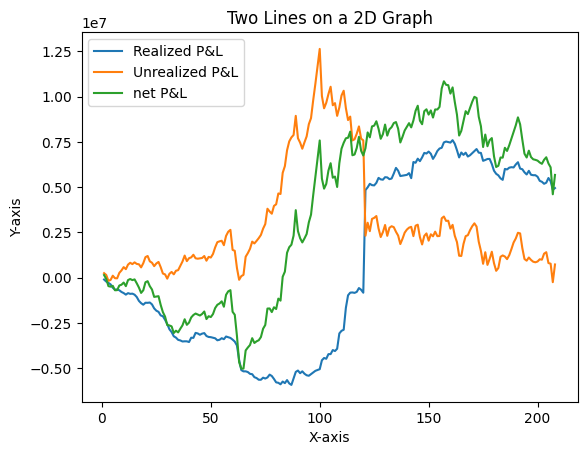

Number of Winners:  550
Number of Losers:  872
Scratched Trades:  92
Win/Loss Ratio:  0.6307339449541285
Average Gain/Loss per Trade:  3747.6787657170817
Max Drawdown: 36.11892409519792
CAGR: 11.89%
Average Return:  0.1892120544010862
Sharpe Ratio: 0.30875797680333583


In [ ]:
import matplotlib.pyplot as plt
print(len(perf), len(unrealized_perf))
x=[]
net_pnl = []
total_trades = winners + losers+scratched
for i in range(len(perf)):
  x.append(i+1)
  net_pnl.append(perf[i]+unrealized_perf[i])

# Plotting the data
plt.plot(x, perf, label='Realized P&L')  # Plot first line
plt.plot(x, unrealized_perf, label='Unrealized P&L')  # Plot second line
plt.plot(x, net_pnl, label='net P&L')  # Plot third line
# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Three Lines on a 2D Graph')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

print("Number of Winners: ", winners)
print("Number of Losers: ", losers)
print("Scratched Trades: ", scratched)

print("Win/Loss Ratio: ", winners/losers)

print("Average Gain/Loss per Trade: ", (positive_pandl+negative_pandl)/total_trades)

result = max_drawdown(net_pnl)
print("Max Drawdown:", result)

start_value = initial_cap  # Initial investment
end_value = initial_cap + net_pnl[207]    # Final value
num_years = 4         # Number of years
# Calculate CAGR
cagr = ((end_value / start_value) ** (1/num_years)) - 1

# Convert to percentage
cagr_percentage = cagr * 100

print("CAGR: {:.2f}%".format(cagr_percentage))

risk_free_rate = 6/100
excess_return = []
one = 92-39
two = 144-39
three = 197-39
four = 248-39
prev = 0
curr=net_pnl[one]
return_yoy = []
return_yoy.append((curr-prev)/initial_cap)
prev = curr + initial_cap
curr = net_pnl[two] + initial_cap
return_yoy.append((curr-prev)/prev)
prev = curr
curr = initial_cap + net_pnl[three]
return_yoy.append((curr-prev)/prev)
prev = curr
curr = initial_cap + net_pnl[four-2]
return_yoy.append((curr-prev)/prev)
for i in range(len(return_yoy)):
  excess_return.append(return_yoy[i]-risk_free_rate)
ret = 0
for i in range(len(return_yoy)):
  ret = ret+return_yoy[i]
average_return = ret/4
print("Average Return: ", average_return)
variance = np.var(excess_return)
# Calculate Standard Deviation
standard_deviation = np.sqrt(variance)

# Calculate Sharpe Ratio
sharpe_ratio = (average_return - risk_free_rate) / standard_deviation

print("Sharpe Ratio:", sharpe_ratio)